In [3]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn import linear_model

In [4]:
%matplotlib inline
from pandas.plotting import scatter_matrix

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import statsmodels.formula.api as sm
import statsmodels.api as sm
from sklearn import tree, preprocessing
import sklearn.ensemble as ske

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [5]:
# Creating Engine
database_path="data/wildfires.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [6]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM wildfirecleaned", conn,parse_dates={'DISC_DATE': '%Y%m%d %H:%M:%S','CONTAIN_DATE':'%Y%m%d %H:%M:%S'})

In [7]:
#Create a variable to calculate total number of days fire contained  
data['TOTAL_DAYS']=data['CONTAIN_DATE']-data['DISC_DATE']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002467BAFEA48>,
      dtype=object)

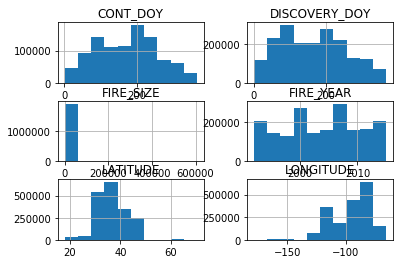

In [8]:
#check the distribution of numeric variables
data.hist()

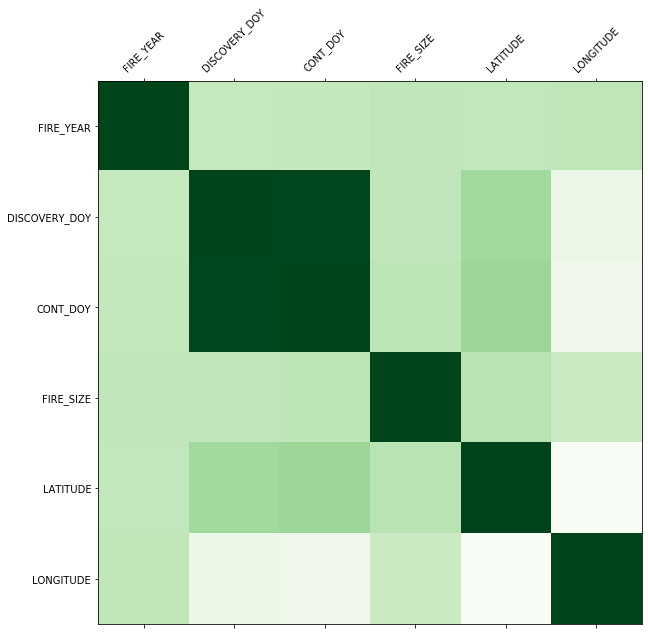

In [9]:
#check for multicollinearity of variables
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Greens)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
plot_corr(data, size=10)

In [10]:
data.describe()

,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,TOTAL_DAYS
count,1.880465e+06,1.880465e+06,988934.000000,1.880465e+06,1.880465e+06,1.880465e+06,988934
mean,2.003710e+03,1.647191e+02,172.656766,7.452016e+01,3.678121e+01,-9.570494e+01,1 days 05:36:33.612920
std,6.663099e+00,9.003891e+01,84.320348,2.497598e+03,6.139031e+00,1.671694e+01,15 days 14:51:12.093534
min,1.992000e+03,1.000000e+00,1.000000,1.000000e-05,1.793972e+01,-1.788026e+02,0 days 00:00:00
25%,1.998000e+03,8.900000e+01,102.000000,1.000000e-01,3.281860e+01,-1.103635e+02,0 days 00:00:00
50%,2.004000e+03,1.640000e+02,181.000000,1.000000e+00,3.545250e+01,-9.204304e+01,0 days 00:00:00
75%,2.009000e+03,2.300000e+02,232.000000,3.300000e+00,4.082720e+01,-8.229760e+01,0 days 00:00:00
max,2.015000e+03,3.660000e+02,366.000000,6.069450e+05,7.033060e+01,-6.525694e+01,4018 days 00:00:00


In [11]:
#Create a new function to find missing values
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
## Check how many are missing by column, and then check which ones have any missing values
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 
#axis=0 defines that function is to be applied on each column

Missing values per column:
CONT_DOY        891531.0
CONTAIN_DATE    891531.0
TOTAL_DAYS      891531.0
dtype: float64


In [12]:
#drop any missing values
data = data.dropna()

In [13]:
#check for the missing values
print("Missing values per column:")
print(data.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 

Missing values per column:
Series([], dtype: float64)


In [14]:
data.shape

(988934, 14)

In [15]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


In [16]:
# converting total days format from timedelta to integer
data['TOTAL_DAYS']=data['TOTAL_DAYS'].apply(lambda x: x.days)

In [17]:
#Encode CAUSE_DESCR with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(data['CAUSE_DESCR'])
data['CAUSE_DESCR']=le.transform(data['CAUSE_DESCR'])

LabelEncoder()

In [18]:
#Encode STATE with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(data['STATE'])
data['STATE']=le.transform(data['STATE'])

LabelEncoder()

In [19]:
#Encode FIRE_CLASS with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(data['FIRE_CLASS'])
data['FIRE_CLASS']=le.transform(data['FIRE_CLASS'])

LabelEncoder()

In [20]:
# dividing the days in number of bins to convert to categories small , medium, large and xlarge
data["DAY_CATEGORY"]=pd.cut(data["TOTAL_DAYS"], bins=[-1,3,5,10,500],labels=['small','medium','large','xlarge'])

In [21]:
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE,TOTAL_DAYS,DAY_CATEGORY
0,Plumas National Forest,2005,33,7,33.0,0.10,0,40.036944,-121.005833,4,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0,small
1,Eldorado National Forest,2004,133,6,133.0,0.25,0,38.933056,-120.404444,4,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12,0,small
2,Eldorado National Forest,2004,152,3,152.0,0.10,0,38.984167,-120.735556,4,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31,0,small
3,Eldorado National Forest,2004,180,6,185.0,0.10,0,38.559167,-119.913333,4,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03,5,medium
4,Eldorado National Forest,2004,180,6,185.0,0.10,0,38.559167,-119.933056,4,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03,5,medium


# Training and Test Datasets

### 1. Predict the cause of a fire wildfire given date, location, total number of days fire contained and size

In [22]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'CAUSE_DESCR'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','TOTAL_DAYS','FIRE_SIZE']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Put some of the classes together and created 4 classes

In [23]:
#4 classes are: natural, accidental, malicious and other
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

data['LABEL'] = data['CAUSE_DESCR'].apply(lambda x: set_label(x))

# Since we'll be using supervised learning we need to create training and test datasets
# Define our dependent variable
y_column = 'LABEL'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','TOTAL_DAYS','FIRE_SIZE']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 2. Predict the size of a fire given date, location, total number of days fire contained and cause

In [24]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'FIRE_SIZE'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','TOTAL_DAYS','CAUSE_DESCR']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Use fire class (categorical variable) instead of fire size (continuous variable)

In [25]:
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'FIRE_CLASS'
y = data[y_column]
# Define our independent variables
x_columns = ['FIRE_YEAR','LATITUDE','LONGITUDE','TOTAL_DAYS','CAUSE_DESCR']
X = data[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets 30% for testing, 70% for training
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression

### Can we use linear regression to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [26]:
# Train and evaluate the model with CAUSE_DESCR variable
#check the model summary
model = sm.OLS(endog=y1_train, exog=X1_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            CAUSE_DESCR   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3266.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:20:41   Log-Likelihood:            -1.9569e+06
No. Observations:              791147   AIC:                         3.914e+06
Df Residuals:                  791141   BIC:                         3.914e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIRE_YEAR      0.0045      0.000     10.296      0.0

In [27]:
# Train and evaluate the model with LABEL variable
#check the model summary
model = sm.OLS(endog=y2_train, exog=X2_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  LABEL   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                -1.384e+05
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               1.00
Time:                        16:20:53   Log-Likelihood:             2.0528e+07
No. Observations:              692253   AIC:                        -4.106e+07
Df Residuals:                  692247   BIC:                        -4.106e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIRE_YEAR  -8.636e-17   5.26e-18    -16.410      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


### Can we use linear regression to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [28]:
# Train and evaluate the model with FIRE_SIZE variable
#check the model summary
model = sm.OLS(endog=y3_train, exog=X3_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              FIRE_SIZE   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1415.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:21:01   Log-Likelihood:            -6.6068e+06
No. Observations:              692253   AIC:                         1.321e+07
Df Residuals:                  692247   BIC:                         1.321e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
FIRE_YEAR       1.9079      0.556      3.433      

In [29]:
# Train and evaluate the model with FIRE_CLASS variable
#check the model summary
model = sm.OLS(endog=y4_train, exog=X4_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             FIRE_CLASS   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4690.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:21:03   Log-Likelihood:            -8.9387e+05
No. Observations:              692253   AIC:                         1.788e+06
Df Residuals:                  692247   BIC:                         1.788e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
FIRE_YEAR      -0.0012      0.000     -8.606      

# Decision Tree

In [33]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters, print_oob_score=False):
    # initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)  
    # training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    y_pred1 = regressor.predict (X_train)
    y_pred2 = regressor.predict (X_test)
   
    # calculating the score of the predictive power on the training and testing dataset.
    print ('Train score: %.3f' % r2_score(y_train, y_pred1))
    print ('Test score: %.3f' % r2_score(y_test, y_pred2))
    # results
    return regressor

### Can we use Decision Tree to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [34]:
# Train and evaluate the model with CAUSE_DESCR variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters={'random_state':42})

Train score: 0.990
Test score: -0.213


#### Parameter tuning

In [35]:
parameters = {"max_depth":8,
              'random_state':42}

# Train and evaluate the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters=parameters)

Train score: 0.237
Test score: 0.231


In [36]:
parameters = {"max_depth":[6,7,8],
              "max_leaf_nodes":[4,5,6]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X1_train, y1_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 7, 8], 'max_leaf_nodes': [4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 6,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [37]:
parameters = {"max_depth":[4,5,6],
              "max_leaf_nodes":[6,7,8],
              'min_samples_leaf': [1,2,3],
              'min_samples_split': [2,3,4]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X1_train, y1_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6], 'max_leaf_nodes': [6, 7, 8],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
       

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [38]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X1_train, 
                                          y_train=y1_train, 
                                          X_test=X1_test, 
                                          y_test=y1_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.119
Test score: 0.117


In [40]:
# Train and evaluate the model with LABEL variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X2_train, 
                                          y_train=y2_train, 
                                          X_test=X2_test, 
                                          y_test=y2_test, 
                                          model_parameters={'random_state':42})

Train score: 1.000
Test score: 1.000


### Can we use Decision Tree to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [41]:
# Train and evaluate the model with FIRE_SIZE variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters={'random_state':42})

Train score: 0.999
Test score: -0.657


#### Parameter tuning

In [42]:
parameters = {"max_depth":8,
              'random_state':42}

# Train and evaluate the model
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters=parameters)

Train score: 0.396
Test score: -0.022


In [43]:
parameters = {"max_depth":[6,7,8],
              "max_leaf_nodes":[4,5,6]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X3_train, y3_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 7, 8], 'max_leaf_nodes': [4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [44]:
parameters = {"max_depth":[4,5,6],
              "max_leaf_nodes":[3,4,5],
              'min_samples_leaf': [1,2,3],
              'min_samples_split': [2,3,4]}
decision_regressor= DecisionTreeRegressor(random_state=42)

# initializing GridSearch and then fit
regressor=GridSearchCV(decision_regressor,parameters)
regressor.fit(X3_train, y3_train)
regressor.best_estimator_.get_params()

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6], 'max_leaf_nodes': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
       

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [45]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X3_train, 
                                          y_train=y3_train, 
                                          X_test=X3_test, 
                                          y_test=y3_test, 
                                          model_parameters=regressor.best_estimator_.get_params())

Train score: 0.132
Test score: 0.153


In [46]:
# Train and evaluate the model with FIRE_CLASS variable
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X4_train, 
                                          y_train=y4_train, 
                                          X_test=X4_test, 
                                          y_test=y4_test, 
                                          model_parameters={'random_state':42})

Train score: 0.987
Test score: -0.046


# Random Forest

### Can we use Random Forest to predict the cause of a fire wildfire, given size, location, date and total number of days fire contained?

In [30]:
# Train and evaluate the model with CAUSE_DESCR variable
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X1_train,y1_train)
print(clf_rf.score(X1_train,y1_train))
print(clf_rf.score(X1_test,y1_test))

0.9932351383497631
0.5832385343829473


In [31]:
# Train and evaluate the model with LABEL variable
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X2_train,y2_train)
print(clf_rf.score(X2_train,y2_train))
print(clf_rf.score(X2_test,y2_test))

1.0
1.0


### Can we use Random Forest to predict the size of a fire wildfire, given cause of a fire wildfire, location, date and total number of days fire contained?

In [32]:
# Train and evaluate the model with FIRE_CLASS variable
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X4_train,y4_train)
print(clf_rf.score(X4_train,y4_train))
print(clf_rf.score(X4_test,y4_test))

0.9863532552404973
0.6180914854675561
